Use `dask.delayed` to parallelize code with threads
==========================

This example shows how to use `dask.delayed` to turn typical Python code into a parallel dask graph and then compute it in parallel.

We start with a simple example computation

In [1]:
from time import sleep

def slowadd(x, y):
    """ Slow version of ``add`` to simulate work """
    sleep(1)
    return x + y

def slowinc(x):
    """ Slow version of ``increment`` to simulate work """
    sleep(1)
    return x + 1

def slowsum(L):
    """ Slow version of ``sum`` to simulate work """
    sleep(0.5)
    return sum(L)

%time slowadd(1, 2)

CPU times: user 1.44 ms, sys: 166 µs, total: 1.61 ms
Wall time: 1 s


3

Real workflows often have a variety of interrelated function calls. 

Below we call `slowadd` and `slowinc` on input data in a few list comprehensions.  We finish by summing the results.  This takes ten seconds to finish.

In [2]:
%%time

data = [1, 2, 3]
A = [slowinc(i) for i in data]
B = [slowadd(a, 10) for a in A]
C = [slowadd(a, 100) for a in A]
result = slowsum(A) + slowsum(B) + slowsum(C)
print(result)

357
CPU times: user 161 µs, sys: 3.97 ms, total: 4.13 ms
Wall time: 10.5 s


Parallelize with `dask.delayed`
------------------------------

We wrap all of our function calls with `dask.delayed`.  This captures the input and, rather than evaluate the function, puts the function and its inputs into a dask graph visualized below.

In [3]:
from dask import delayed

In [4]:
%%time

data = [1, 2, 3]
A = [delayed(slowinc)(i) for i in data]
B = [delayed(slowadd)(a, 10) for a in A]
C = [delayed(slowadd)(a, 100) for a in A]
result = delayed(slowsum)(A) + delayed(slowsum)(B) + delayed(slowsum)(C)

CPU times: user 1.38 ms, sys: 174 µs, total: 1.56 ms
Wall time: 1.45 ms


This returned instantly because we haven't done any actual work yet. Instead this code builds up a graph of computations.  We visualize that graph below.

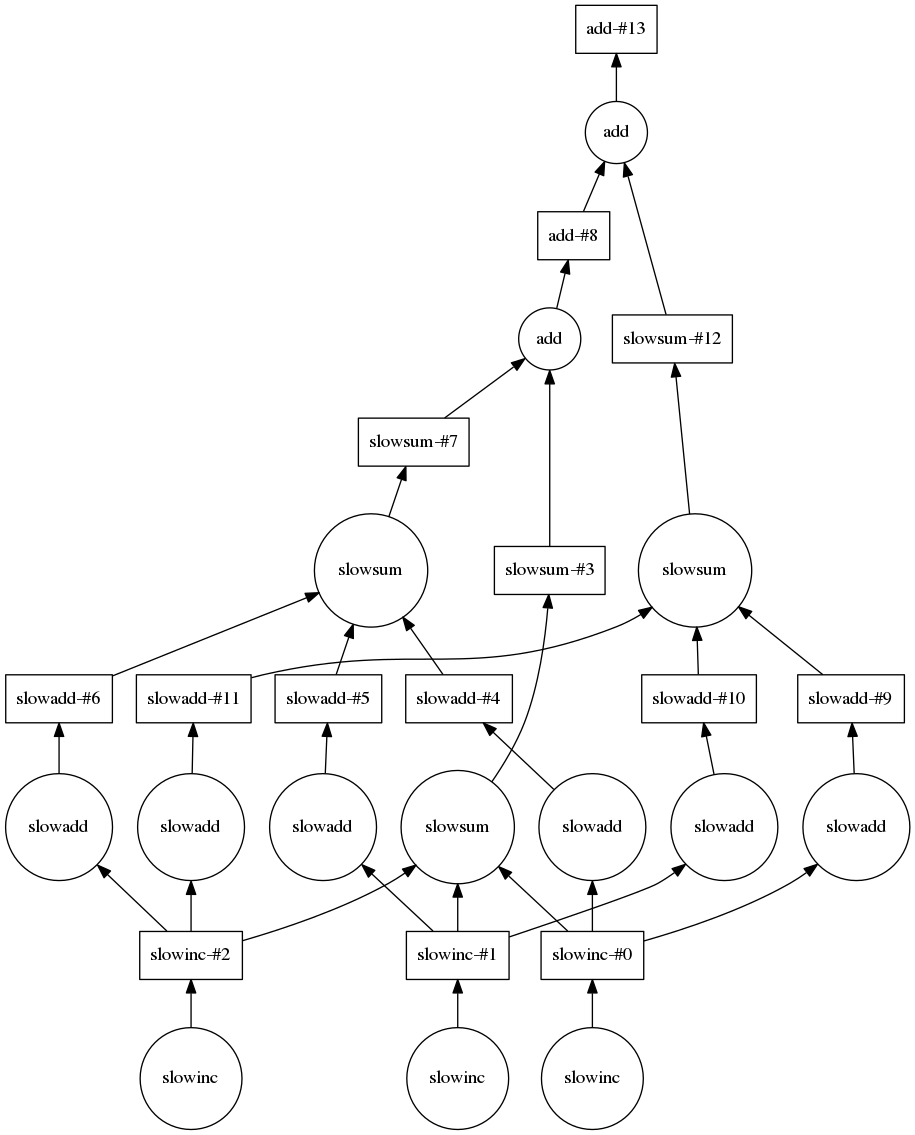

In [5]:
try:
    img = result.visualize()
except RuntimeError as e:        # User may not have graphviz.  Load precomputed result from file.
    print(e.args[0])
    from IPython.display import Image
    img = Image('images/do-and-profiler-graph.png')

img

Compute result
----------------

This work can happen in parallel.  We execute the computation by calling the `compute` method on our result.

In [6]:
%time result.compute()

CPU times: user 32.8 ms, sys: 180 µs, total: 33 ms
Wall time: 3.52 s


357

Use the Profiler to gain intuition
---------------------------------------

We use the dask `Profiler` to gain intuition about how our computation was run.

*Note for readers on github, this plot won't show up on github's notebook viewer.  You can see the results by doing one of the following:*

1.  Run this notebook yourself
2.  See saved results at [this saved plot](https://cdn.rawgit.com/blaze/dask-examples/16e722631e6217cf08598a6f3ad73f1fb9bb3e82/profiles/timeseries.html)

In [7]:
from bokeh.plotting import output_notebook
output_notebook()

Loading BokehJS ...

In [8]:
from dask.diagnostics import Profiler
prof = Profiler()

with prof:
    result.compute()

prof.visualize()

Figure(id='f48b70ec-3bb8-42d5-8f1e-9b2e386cbc9e', ...)